In [1]:
!pip install astro-datasets numpy matplotlib albumentations

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-23 17:51:49.612337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'T', 
                                                 'parameters': ['omegam']})

2022-11-23 17:51:51.955851: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/IllustrisTNG_T_omegam/cmd/1.0.4.incomplete7E4ENR/cmd-train.tfrecord*...:  …

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/IllustrisTNG_T_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


2022-11-23 17:56:00.254762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 17:56:00.785002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c4:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'T', 
                                                 'parameters': ['omegam']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/SIMBA_T_omegam/cmd/1.0.4.incompleteLAKWFO/cmd-train.tfrecord*...:   0%|   …

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/SIMBA_T_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_train = simba_train.repeat(count=3) # increase dataset size
simba_train = simba_train.map(process_data)
simba_train = simba_train.map(set_shapes)
simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_val = simba_val.map(normalize)
simba_val = simba_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(cmd_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=cmd_val)

Epoch 1/50


2022-11-23 18:00:13.677908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-23 18:00:16.434417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-23 18:00:16.438108: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x60c1a8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-23 18:00:16.438175: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-23 18:00:16.446795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-23 18:00:16.590765: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

317/317 [==============================] - ETA: 0s - loss: 0.2627 - mse: 0.6428
Epoch 1: val_loss improved from inf to 0.54416, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 117s 322ms/step - loss: 0.2627 - mse: 0.6428 - val_loss: 0.5442 - val_mse: 0.3531 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.0836 - mse: 0.0792
Epoch 2: val_loss did not improve from 0.54416
317/317 [==============================] - 95s 300ms/step - loss: 0.0836 - mse: 0.0792 - val_loss: 1.1278 - val_mse: 1.4142 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0594 - mse: 0.0442
Epoch 3: val_loss improved from 0.54416 to 0.33207, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 322ms/step - loss: 0.0594 - mse: 0.0442 - val_loss: 0.3321 - val_mse: 0.1337 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0494 - mse: 0.0275
Epoch 4: val_loss improved from 0.33207 to 0.26385, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 319ms/step - loss: 0.0494 - mse: 0.0275 - val_loss: 0.2639 - val_mse: 0.0794 - lr: 0.0010
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.0388 - mse: 0.0118
Epoch 5: val_loss did not improve from 0.26385
317/317 [==============================] - 95s 300ms/step - loss: 0.0388 - mse: 0.0118 - val_loss: 0.3080 - val_mse: 0.1094 - lr: 0.0010
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.0338 - mse: 0.0066
Epoch 6: val_loss improved from 0.26385 to 0.07835, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 101s 319ms/step - loss: 0.0338 - mse: 0.0066 - val_loss: 0.0784 - val_mse: 0.0091 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0039
Epoch 7: val_loss did not improve from 0.07835
317/317 [==============================] - 94s 297ms/step - loss: 0.0315 - mse: 0.0039 - val_loss: 0.3113 - val_mse: 0.1170 - lr: 0.0010
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0031
Epoch 8: val_loss did not improve from 0.07835
317/317 [==============================] - 95s 298ms/step - loss: 0.0288 - mse: 0.0031 - val_loss: 0.1595 - val_mse: 0.0351 - lr: 0.0010
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0031
Epoch 9: val_loss did not improve from 0.07835
317/317 [==============================] - 94s 297ms/step - loss: 0.0288 - mse: 0.0031 - val_loss: 0.1853 - val_mse: 0.0415 - lr: 0.0010
Epoch 10/50
317/317 [================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 100s 316ms/step - loss: 0.0289 - mse: 0.0021 - val_loss: 0.0385 - val_mse: 0.0024 - lr: 0.0010
Epoch 12/50
317/317 [==============================] - ETA: 0s - loss: 0.0266 - mse: 0.0022
Epoch 12: val_loss did not improve from 0.03851
317/317 [==============================] - 95s 300ms/step - loss: 0.0266 - mse: 0.0022 - val_loss: 0.0402 - val_mse: 0.0021 - lr: 0.0010
Epoch 13/50
317/317 [==============================] - ETA: 0s - loss: 0.0284 - mse: 0.0027
Epoch 13: val_loss did not improve from 0.03851
317/317 [==============================] - 94s 298ms/step - loss: 0.0284 - mse: 0.0027 - val_loss: 0.0625 - val_mse: 0.0067 - lr: 0.0010
Epoch 14/50
317/317 [==============================] - ETA: 0s - loss: 0.0259 - mse: 0.0022
Epoch 14: val_loss did not improve from 0.03851
317/317 [==============================] - 95s 301ms/step - loss: 0.0259 - mse: 0.0022 - val_loss: 0.0642 - val_mse: 0.0068 - lr: 0.0010
Epoch 15/50
317/317 [==========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 111s 351ms/step - loss: 0.0179 - mse: 7.5882e-04 - val_loss: 0.0364 - val_mse: 0.0025 - lr: 3.0000e-04
Epoch 24/50
317/317 [==============================] - ETA: 0s - loss: 0.0178 - mse: 7.6725e-04
Epoch 24: val_loss did not improve from 0.03638
317/317 [==============================] - 97s 307ms/step - loss: 0.0178 - mse: 7.6725e-04 - val_loss: 0.1045 - val_mse: 0.0152 - lr: 3.0000e-04
Epoch 25/50
317/317 [==============================] - ETA: 0s - loss: 0.0175 - mse: 6.8968e-04
Epoch 25: val_loss did not improve from 0.03638
317/317 [==============================] - 97s 307ms/step - loss: 0.0175 - mse: 6.8968e-04 - val_loss: 0.0659 - val_mse: 0.0058 - lr: 3.0000e-04
Epoch 26/50
317/317 [==============================] - ETA: 0s - loss: 0.0175 - mse: 7.4179e-04
Epoch 26: val_loss did not improve from 0.03638
317/317 [==============================] - 104s 328ms/step - loss: 0.0175 - mse: 7.4179e-04 - val_loss: 0.1945 - val_mse: 0.0462 - l

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 106s 333ms/step - loss: 0.0166 - mse: 6.6013e-04 - val_loss: 0.0308 - val_mse: 0.0018 - lr: 3.0000e-04
Epoch 34/50
317/317 [==============================] - ETA: 0s - loss: 0.0166 - mse: 6.7145e-04
Epoch 34: val_loss did not improve from 0.03079
317/317 [==============================] - 98s 309ms/step - loss: 0.0166 - mse: 6.7145e-04 - val_loss: 0.1065 - val_mse: 0.0163 - lr: 3.0000e-04
Epoch 35/50
317/317 [==============================] - ETA: 0s - loss: 0.0163 - mse: 6.6785e-04
Epoch 35: val_loss improved from 0.03079 to 0.02362, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 113s 356ms/step - loss: 0.0163 - mse: 6.6785e-04 - val_loss: 0.0236 - val_mse: 8.6681e-04 - lr: 3.0000e-04
Epoch 36/50
317/317 [==============================] - ETA: 0s - loss: 0.0161 - mse: 6.6761e-04
Epoch 36: val_loss did not improve from 0.02362
317/317 [==============================] - 100s 316ms/step - loss: 0.0161 - mse: 6.6761e-04 - val_loss: 0.0357 - val_mse: 0.0019 - lr: 3.0000e-04
Epoch 37/50
317/317 [==============================] - ETA: 0s - loss: 0.0161 - mse: 6.4872e-04
Epoch 37: val_loss did not improve from 0.02362
317/317 [==============================] - 101s 317ms/step - loss: 0.0161 - mse: 6.4872e-04 - val_loss: 0.0854 - val_mse: 0.0121 - lr: 3.0000e-04
Epoch 38/50
317/317 [==============================] - ETA: 0s - loss: 0.0157 - mse: 5.9406e-04
Epoch 38: val_loss did not improve from 0.02362
317/317 [==============================] - 97s 304ms/step - loss: 0.0157 - mse: 5.9406e-04 - val_loss: 0.1272 - val_mse: 0.021

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 105s 331ms/step - loss: 0.0125 - mse: 3.3044e-04 - val_loss: 0.0234 - val_mse: 0.0011 - lr: 9.0000e-05
Epoch 48/50
317/317 [==============================] - ETA: 0s - loss: 0.0124 - mse: 3.2762e-04
Epoch 48: val_loss did not improve from 0.02344
317/317 [==============================] - 98s 308ms/step - loss: 0.0124 - mse: 3.2762e-04 - val_loss: 0.0326 - val_mse: 0.0021 - lr: 9.0000e-05
Epoch 49/50
317/317 [==============================] - ETA: 0s - loss: 0.0122 - mse: 3.1680e-04
Epoch 49: val_loss did not improve from 0.02344
317/317 [==============================] - 98s 308ms/step - loss: 0.0122 - mse: 3.1680e-04 - val_loss: 0.0265 - val_mse: 9.8516e-04 - lr: 9.0000e-05
Epoch 50/50
317/317 [==============================] - ETA: 0s - loss: 0.0121 - mse: 3.0927e-04
Epoch 50: val_loss did not improve from 0.02344
317/317 [==============================] - 97s 307ms/step - loss: 0.0121 - mse: 3.0927e-04 - val_loss: 0.0343 - val_mse: 0.0016 

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 30ms/step - loss: 0.0240 - mse: 0.0011


[0.024011993780732155, 0.0011092242784798145]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.1159 - mse: 0.0202


[0.11593130230903625, 0.020184794440865517]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 24ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 1s 25ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.07210078

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.5610446

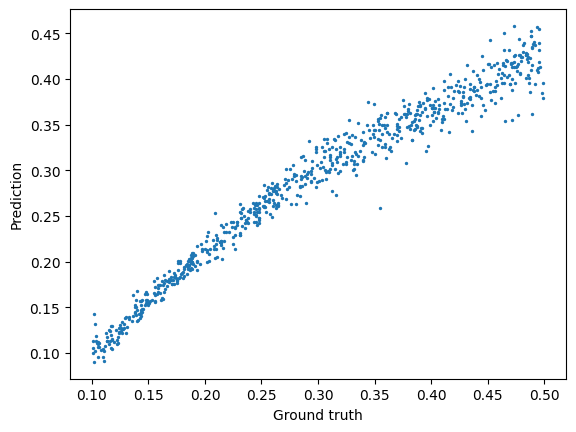

In [26]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()